Load file and remove background signal

In [ ]:
%load_ext autoreload
%autoreload 2

Performing background subtraction...
Successfully subtracted background.


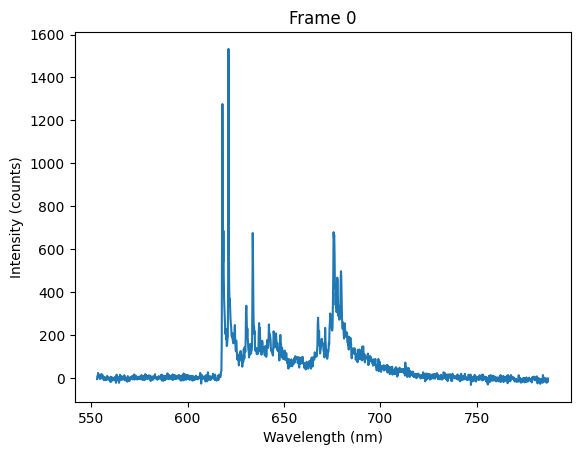

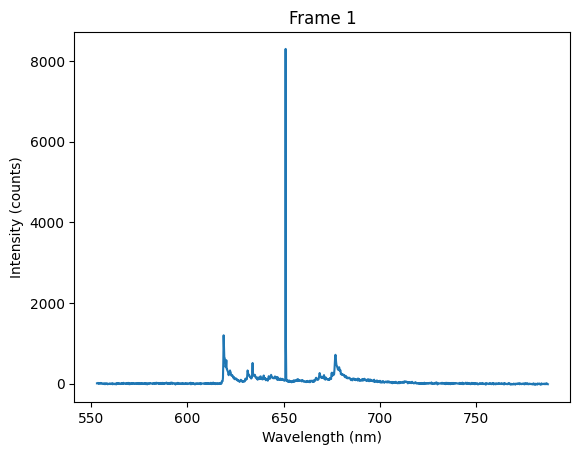

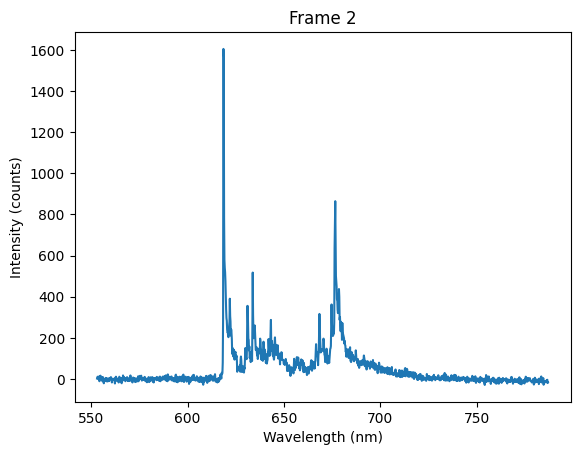

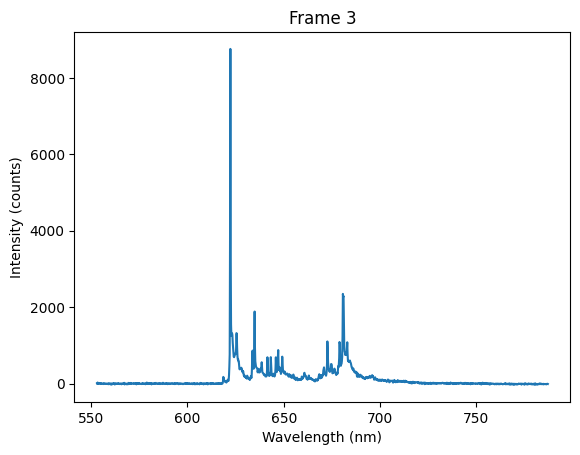

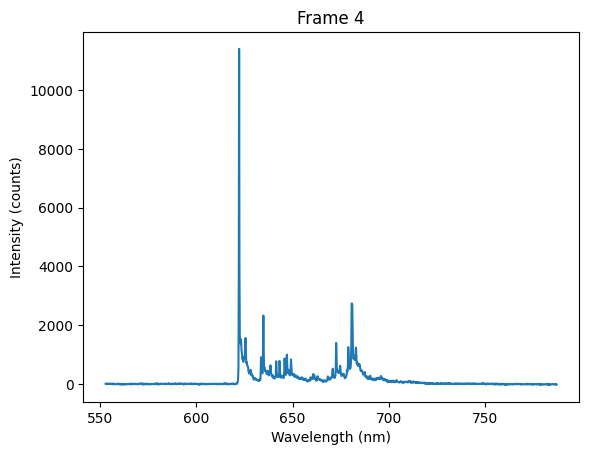

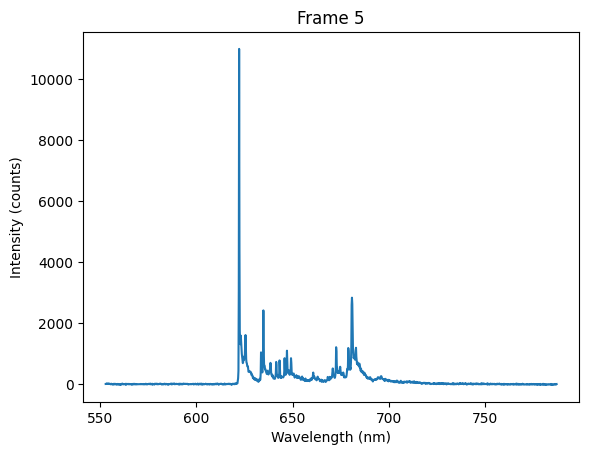

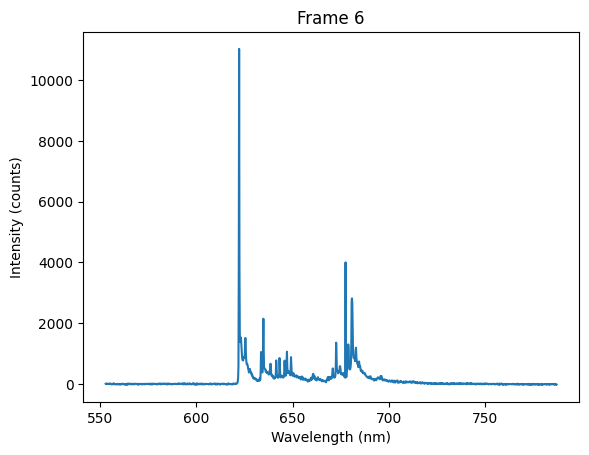

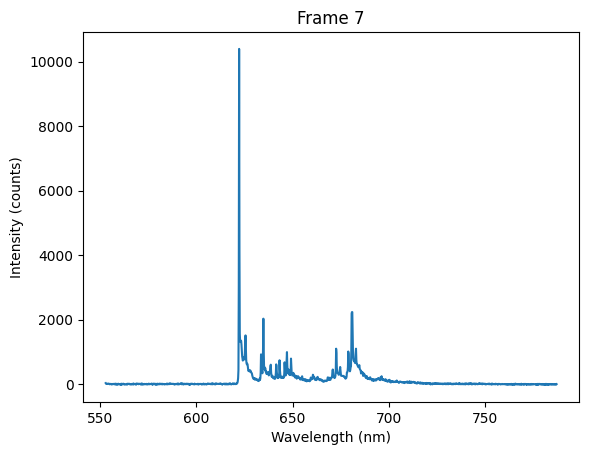

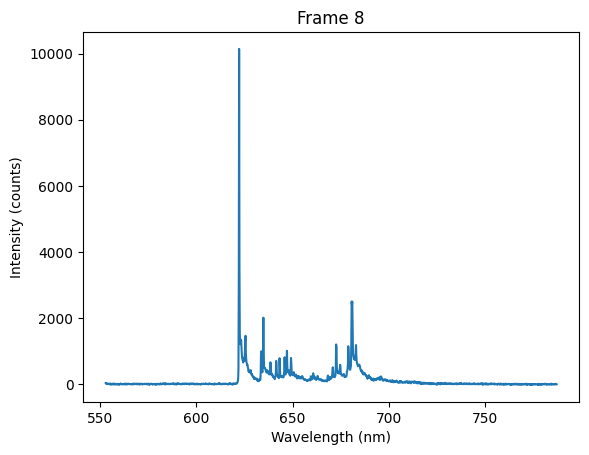

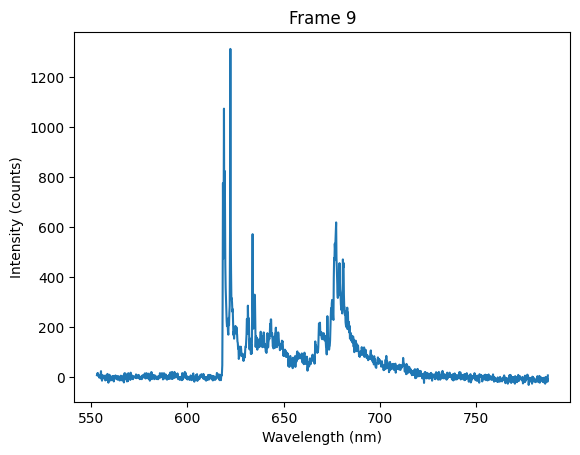

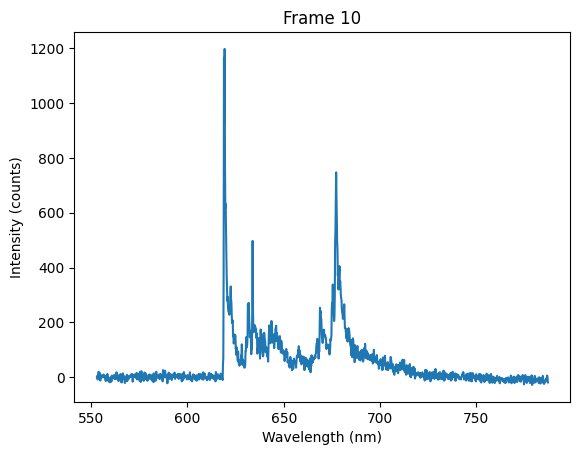

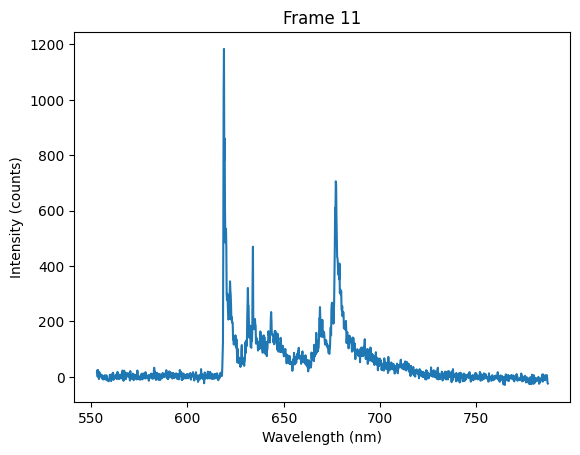

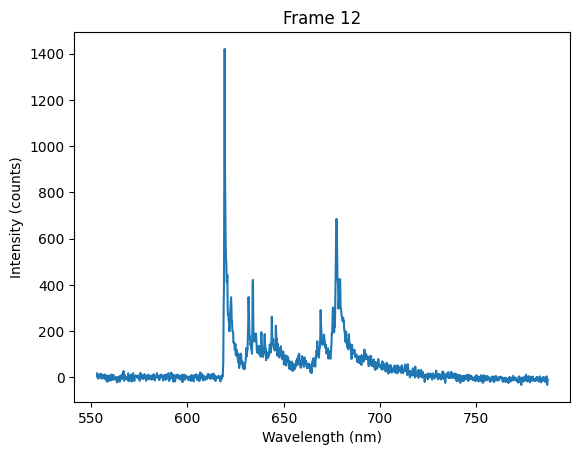

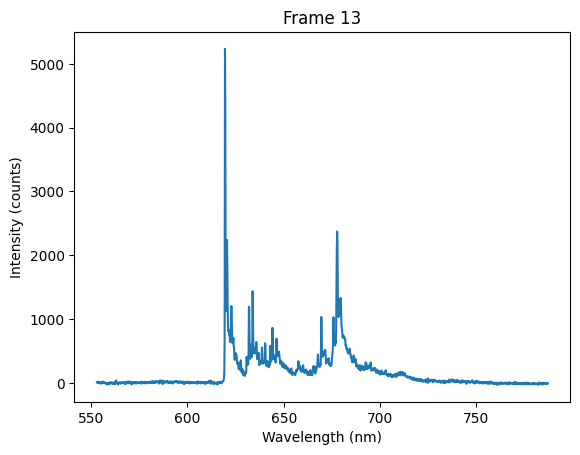

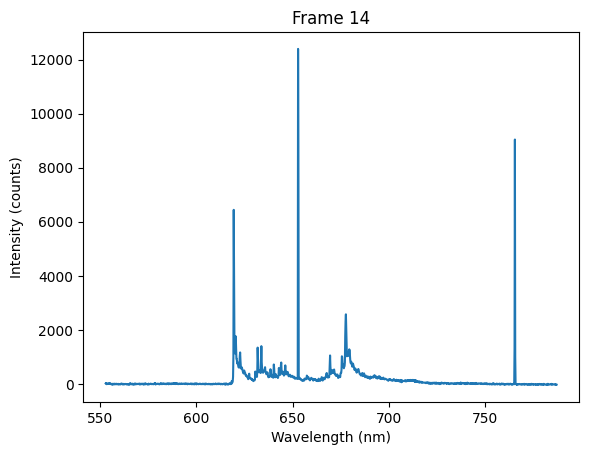

In [8]:
from pathlib import Path

import hbn_pl.io as io
import hbn_pl.preprocess as preprocess
import hbn_pl.plot as plot
import hbn_pl.peaks as peaks
import hbn_pl.energy as energy

DATA_DIR = 'C:\\Users\\ech77\\OneDrive - University of Cambridge\\Data for IBS November 2025\\Sample 5\\PL spectra'
DATA_DIR = Path(DATA_DIR)
FILE_NAME = '2025-11-17 16_29_50 sample5_DCMd2_200uw_emitter6 2184.spe'
#frames = frames[0:15]
FILE_NAME = '2025-11-17 17_34_30 sample5_DCMd2_200uw_emitter11 2189.spe'
#FILE_NAME = '2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195.spe'
spe_path = DATA_DIR / FILE_NAME
wavelength, frames = io.load_spe(spe_path)
frames = frames[0:15]
frames = preprocess.background_subtract(frames, bg_slice=(1, 50))
plot.plot_frames(wavelength, frames)

Cosmic ray removal

Normalising frames...
Successfully normalised frames.
Detected 3 cosmic ray frames: [1, 6, 14]
Cosmic ray wavelengths: [np.float64(650.9426357271755), np.float64(677.5173279117514), np.float64(765.4112890047277)]
Removing cosmic rays from 3 frames: [1, 6, 14]


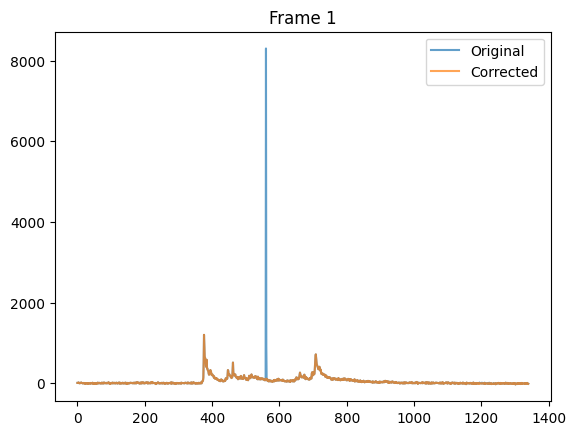

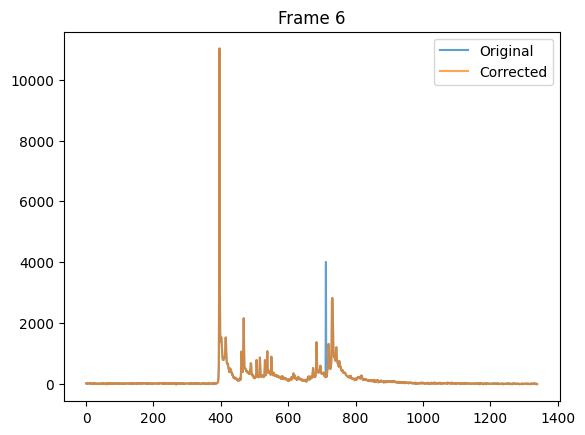

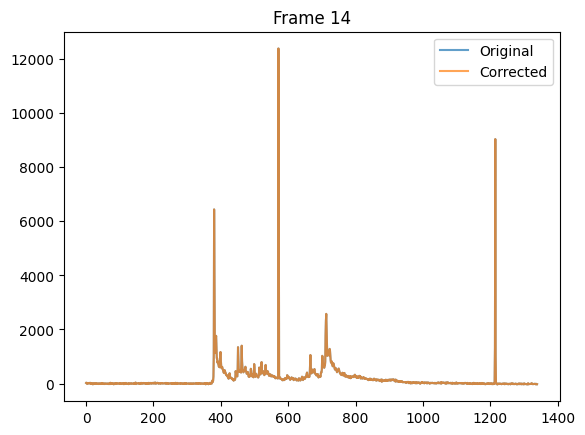

Successfully removed cosmic rays.
[ 571 1215  380]
[1.78528523 1.15207408 1.87968427]


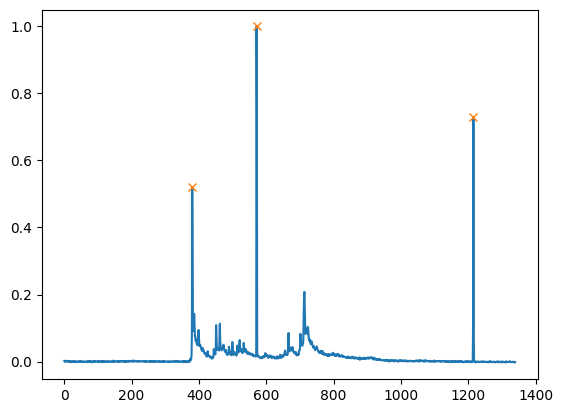

In [21]:
frames_norm = preprocess.normalise(frames)
#cosmic_frames = preprocess.detect_cosmic_frames(frames_norm, sigma_threshold=90, min_outliers=3)
#frames = preprocess.remove_cosmic_rays(frames, cosmic_frames, sigma=2.5)

cosmic_frames, cosmic_location = preprocess.detect_cosmic_frames2(frames_norm, wavelength, prominence_threshold=0.2, fwhm_threshold=1.3, n_peaks=3)
frames_cleaned = preprocess.remove_cosmic_rays2(frames, wavelength, cosmic_frames, cosmic_location, sigma=1.5, half_width = 5)


import numpy
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
spectrum = frames_norm[14]
peaks, properties = find_peaks(spectrum, prominence=0.3)

# Sort peaks by prominence (descending)
prominences = properties["prominences"]
sorted_idx = numpy.argsort(prominences)[::-1]
top_idx = sorted_idx[:3]
top_peaks = peaks[top_idx]

# Compute FWHM for selected peaks
fwhm_values, _, left_ips, right_ips = peak_widths(spectrum,top_peaks,rel_height=0.5)
print(top_peaks)
print(fwhm_values)

plt.plot(spectrum)
plt.plot(top_peaks, spectrum[top_peaks], "x")


Bad frame removal

In [ ]:
drop_fraction = 0.6
bad_frames = preprocess.detect_bad_frames_simple(frames, drop_fraction = drop_fraction)
#bad_frames = preprocess.detect_bad_frames_complex(frames, window = 5, drop_fraction = drop_fraction)
#frames = preprocess.remove_frames(frames, bad_frames)

Average and normalise

In [ ]:
avg, avg_norm = preprocess.average_and_normalise(frames)
plot.plot_spectrum(wavelength, avg_norm)

## Peak finding

In [ ]:
import hbn_pl.peaks2 as peaks2
import hbn_pl.classification2 as classification

In [ ]:
finder = peaks2.PeakFinder(wavelength, avg_norm)

finder.peak_finding(prominence=0.1)

peaks = finder.extract_peak_parameters()

print("Detected peaks:")
for p in peaks:
    print(p)

finder.plot_peaks()


## Classification

In [ ]:
classifier = classification.ZPLClassification(peaks, thresholds={
            "max_fwhm": 0.9,           
            "min_prominence": 0.5,   
            "location_range": [615, 640]    
        })

result = classifier.classify()

print(result)

